In [1]:
# Preload the interleaf data 

from datasets import load_dataset

dataset = load_dataset("HuggingFaceH4/ultrafeedback_binarized", split='train_prefs')

/home/ubuntu/mambaforge-pypy3/envs/llava/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
len(dataset)

61966

In [6]:
df = dataset.to_pandas()

In [7]:
def get_response_from_list_of_dict(list_of_dict):
    for d in list_of_dict:
        if d['role'] == "assistant":
            assert d['content'] is not None and isinstance(d['content'], str)
            return d['content']

In [8]:
df['chosen'] = df['chosen'].apply(get_response_from_list_of_dict)
df['rejected'] = df['rejected'].apply(get_response_from_list_of_dict)

In [9]:
df['question'] = df['prompt']

In [10]:
df['rejected'].str.contains("</s>").sum()

697

In [11]:
df['chosen'].str.contains("</s>").sum()

120

In [12]:
df['question'].str.contains("</s>").sum()

0

In [13]:
filtered_df = df[~df['rejected'].str.contains("</s>") & ~df['chosen'].str.contains("</s>") & ~df['question'].str.contains("</s>")]


In [14]:
len(filtered_df), len(df)

(61149, 61966)

In [15]:
filtered_df['question'].str.contains("</s>").sum()

0

In [17]:
indes_find = filtered_df['rejected'].str.contains("</s>")
indes_find.any()

False

In [18]:
intermediate_csv = '/home/ubuntu/latest_llava/LLaVA/playground/data/dpo/ultrafeedback_binarized_2k_sample.csv'
new_df = filtered_df.sample(n=2000, random_state=42)
new_df.to_csv(intermediate_csv)

In [ ]:
import torch
import os
import json
import pandas as pd
from tqdm import tqdm
import shortuuid

from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.conversation import conv_templates, SeparatorStyle
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from llava.mm_utils import tokenizer_image_token, process_images, load_image_from_base64, get_model_name_from_path
from llava.train.train import preference_collator_fn
from functools import partial
import tqdm
from llava.train.llava_trainer import get_batch_logps
from PIL import Image
import math
disable_torch_init()
model_path = '/home/ubuntu/latest_llava/LLaVA/checkpoints/llava-v1.5-13b'
model_base = None
model_name = get_model_name_from_path(model_path)
tokenizer, model, image_processor, context_len = load_pretrained_model(model_path, model_base, model_name)

use_im_start_end= False # Default setting from llava 1.5 

IMAGE_FOLDER="/home/ubuntu/latest_llava/llava_1dot5data/coco/train2017/"
inference_data_path = intermediate_csv
output_path = intermediate_csv.split('csv')[0] + 'with_logp.json'
from llava.train.train import encode_multimodal_preference_sample
import torch.utils.data as torch_data

class PreferenceInferenceDataset(torch_data.Dataset):
    def __init__(self,
                 data_path,
                 tokenizer,
                 img_processor,
                 use_im_start_end):
        self.data = pd.read_csv(data_path)
        for col in ['chosen', 'rejected', 'question']:
            self.data[col] = self.data[col].astype(str)
        self.mm_cfg = {
            'image_processor': img_processor,
            'is_multimodal': False,
            # 'image_token_len': image_token_len, # TODO check if needed
            'use_im_start_end': use_im_start_end,
            'image_aspect_ratio': 'pad'
        }
        self.tokenizer = tokenizer

    def __getitem__(self, index):
        # After encode multimodal preference sample, 
        # the image would ahve the pixel values values
        sample = self.convert_dataframe_row_to_source(self.data.iloc[index])
        rej_data_dict, win_data_dict = encode_multimodal_preference_sample(sample, self.tokenizer, self.mm_cfg)
        return rej_data_dict, win_data_dict
    
    def _get_image(self, img_filename):
        img_path = os.path.join(IMAGE_FOLDER, img_filename)
        image = Image.open(img_path).convert('RGB')
        return image
    

    def _convert_to_llava_answer_turn(self, answer):
        return {"from": "gpt", "value": answer}
    
    def _convert_to_llava_question_turn(self, question):
        return {"from": "human", "value": question}

    def convert_dataframe_row_to_source(self, row):
        dict_output = {'question': self._convert_to_llava_question_turn(row['question']), 
                       # Chosen and rejected based on the sum of the first three quality score
                    'chosen': self._convert_to_llava_answer_turn(row['chosen']),
                    'rejected': self._convert_to_llava_answer_turn(row['rejected'])}
        return dict_output

    def __len__(self):
        return len(self.data)
    
preference_torch_dataset = PreferenceInferenceDataset(inference_data_path,
                           tokenizer=tokenizer,
                           img_processor=image_processor,
                           use_im_start_end=False)
preference_torch_dataset[0]

dataset = preference_torch_dataset
collate_fn = partial(preference_collator_fn, pad_token_id=tokenizer.pad_token_id)
dataloader = torch_data.DataLoader(dataset, batch_size=1, collate_fn=collate_fn,
                                    num_workers=5, shuffle=False)
win_logp_list = []
rej_logp_list = []

win_avg_logp_list = []
rej_avg_logp_list = []

win_per_token_logp_list = []
rej_per_token_logp_list = []

with torch.inference_mode():
    for batch in tqdm.tqdm(dataloader, miniters=50):
        for key in ['win', 'rej']:
            input_ids = batch[f'{key}_input_ids'].cuda()
            labels = batch[f'{key}_labels'].cuda()
            attention_mask = batch[f'{key}_attention_mask'].cuda()

            output = model(
                input_ids=input_ids,
                labels=labels,
                attention_mask=attention_mask,
                images=None,
            )
            per_token_logp, log_prob, average_log_prob = get_batch_logps(output.logits, labels, return_all=True)

            # print(per_token_logp.shape, input_ids.shape, labels.shape, flush=True)
            assert per_token_logp.size(1) >= input_ids.size(1) - 1
            per_token_logp = per_token_logp.tolist()
            # per_token_logp = [x[:input_ids[i].ne(tokenizer.pad_token_id).sum().item()] for i, x in enumerate(per_token_logp)]
            log_prob = log_prob.tolist()
            average_log_prob = average_log_prob.tolist()

            if key == 'win':
                win_logp_list += log_prob
                win_avg_logp_list += average_log_prob
                win_per_token_logp_list += per_token_logp
            else:
                rej_logp_list += log_prob
                rej_avg_logp_list += average_log_prob
                rej_per_token_logp_list += per_token_logp
            # print(f'{key} logits in {output.logits.shape}, logp in {log_prob.shape} avg_logp in {average_log_prob.shape}')

df = pd.read_csv(inference_data_path)
def _convert_to_llava_answer_turn(answer):
    return {"from": "gpt", "value": answer}
# Add each list as a column to the dataframe with its variable name
df['win_logp'] = win_logp_list
df['rej_logp'] = rej_logp_list
df['win_avg_logp'] = win_avg_logp_list
df['rej_avg_logp'] = rej_avg_logp_list
df['win_per_token_logp'] = win_per_token_logp_list
df['rej_per_token_logp'] = rej_per_token_logp_list
exisitng_columns = ['rej_logp', 
                    'win_logp',
                    'rej_avg_logp',
                    'win_avg_logp',
                    'rej_per_token_logp',
                    'win_per_token_logp']
for col in exisitng_columns:
    rename = 'ref_' + col
    df[rename] = df[col]
    del df[col]
df['chosen'] = df['chosen'].apply(_convert_to_llava_answer_turn)
df['rejected'] = df['rejected'].apply(_convert_to_llava_answer_turn)
def _convert_to_llava_question_turn(question):
    return {"from": "human", "value": question}
df['question'] = df['question'].apply(_convert_to_llava_question_turn)
# df.to_json(output_path, orient='records')

In [ ]:
%debug

In [61]:
df.to_json('/home/ubuntu/latest_llava/LLaVA/playground/data/dpo/ultrafeedback/6ksamples.json', orient='records')

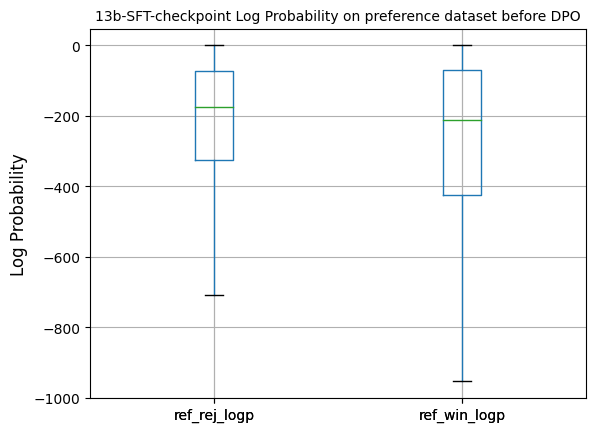

In [63]:
import matplotlib.pyplot as plt

plt.title('13b-SFT-checkpoint Log Probability on preference dataset before DPO', fontsize=10)

# Set the x-ticks
plt.xticks([1, 2], ['Rejected Responses', 'Preferred Reponses'])
plt.ylabel('Log Probability', fontsize=12)

# Create the box plot without outliers
df[['ref_rej_logp', 'ref_win_logp']].boxplot(showfliers=False)

# Save the plot in high DPI and PDF format
# plt.savefig('output.pdf', dpi=300)
plt.show()


In [26]:
import pandas as pd

df_reload = pd.read_json('/home/ubuntu/latest_llava/LLaVA/playground/data/dpo/ultrafeedback_binarized_2k_sample.with_logp.json')
df_reload.dropna(inplace=True)
df_reload.to_json('/home/ubuntu/latest_llava/LLaVA/playground/data/dpo/ultrafeedback_binarized_2k_sample.with_logp.json', orient='records')

In [32]:
df_reload.sample(30)[['chosen', 'rejected']].values

array([[{'from': 'gpt', 'value': 'This is an extremely exciting research from an intellectual standpoint, and scientists will want to conduct it.'},
        {'from': 'gpt', 'value': 'This is a highly exciting research intellectually, and scientists will want to make it.'}],
       [{'from': 'gpt', 'value': "Social Media Audit Proposal\nDear [Nonprofit Organization],\nWe are pleased to submit this proposal for a social media audit of your organization's social media presence. As a top-tier AI assistant, I am committed to providing accurate, current, and engaging content to help you achieve your goals.\nIn order to ensure the success of your social media strategy, it is essential to regularly evaluate and optimize your social media presence. A social media audit is an indispensable tool that enables organizations to assess their social media activities, identify strengths and weaknesses, and develop a strategy to enhance their online presence.\nOur social media audit process will assess 

In [23]:
df_reload['chosen'].apply(lambda x: x['value']).str.contains("</s>").sum()

0

In [24]:
df_reload['rejected'].apply(lambda x: x['value']).str.contains("</s>").sum()

0

In [2]:
df_reload['chosen'] = df_reload['chosen'].apply(_convert_to_llava_answer_turn)
df_reload['rejected'] = df_reload['rejected'].apply(_convert_to_llava_answer_turn)

NameError: name 'df_reload' is not defined

In [3]:
df_reload['rejected']

NameError: name 'df_reload' is not defined

In [7]:
df.to_json('/home/ubuntu/LLaVA/playground/data/dpo/dpo_logp.json', orient='records')


# Old draft below

In [8]:
import torch
import os
import json
import pandas as pd
from tqdm import tqdm
import shortuuid

from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.conversation import conv_templates, SeparatorStyle
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from llava.mm_utils import tokenizer_image_token, process_images, load_image_from_base64, get_model_name_from_path

from PIL import Image
import math
disable_torch_init()
model_path = '/home/ubuntu/LLaVA/checkpoints/llava-v1.5-13b'
model_name = get_model_name_from_path(model_path)
tokenizer, model, image_processor, context_len = load_pretrained_model(model_path, None, model_name)

Loading checkpoint shards: 100%|██████████| 3/3 [00:06<00:00,  2.06s/it]


.....Loading vision tower and image processor...


In [9]:
use_im_start_end= False # Default setting from llava 1.5 

IMAGE_FOLDER='/home/ubuntu/train2017'


In [10]:
# Inspect previous setup

df_muffin_tsv = '/home/ubuntu/muffin/data/RLHF-V-Hall_v0/RLHF-V-Hall_v0-1837.tsv'
df = pd.read_csv(df_muffin_tsv, sep='\t')

In [11]:
from llava.train.train import encode_multimodal_preference_sample
import torch.utils.data as torch_data

class PreferenceInferenceDataset(torch_data.Dataset):
    def __init__(self,
                 data_path,
                 tokenizer,
                 img_processor,
                 use_im_start_end):
        self.data = pd.read_csv(data_path, sep='\t')

        self.mm_cfg = {
            'image_processor': img_processor,
            'is_multimodal': True,
            # 'image_token_len': image_token_len, # TODO check if needed
            'use_im_start_end': use_im_start_end,
            'image_aspect_ratio': 'pad'
        }
        self.tokenizer = tokenizer

    def __getitem__(self, index):
        # After encode multimodal preference sample, 
        # the image would ahve the pixel values values
        sample = self.convert_dataframe_row_to_source(self.data.iloc[index])
        rej_data_dict, win_data_dict = encode_multimodal_preference_sample(sample, self.tokenizer, self.mm_cfg)
        return rej_data_dict, win_data_dict
    
    def _get_image(self, img_filename):
        img_path = os.path.join(IMAGE_FOLDER, img_filename)
        image = Image.open(img_path).convert('RGB')
        return image
    

    def _convert_to_llava_answer_turn(self, answer):
        return {"from": "gpt", "value": answer}

    def convert_dataframe_row_to_source(self, row):
        dict_output = {'question': row['question'], 
                       # Chosen and rejected based on the sum of the first three quality score
                    'chosen': self._convert_to_llava_answer_turn(row['chosen']),
                    'rejected': self._convert_to_llava_answer_turn(row['rejected']),
                    'image': self._get_image(row['image'])}
        return dict_output

    def __len__(self):
        return len(self.data)
    
preference_torch_dataset = PreferenceInferenceDataset('/home/ubuntu/muffin/data/RLHF-V-Hall_v0/RLHF-V-Hall_v0-1837.tsv',
                           tokenizer=tokenizer,
                           img_processor=image_processor,
                           use_im_start_end=False)
preference_torch_dataset[0]

({'input_ids': tensor([    1,   319, 13563,  1546,   263, 12758,  1404,   322,   385, 23116,
          21082, 20255, 29889,   450, 20255,  4076,  8444, 29892, 13173, 29892,
            322,  1248,   568,  6089,   304,   278,  1404, 29915, 29879,  5155,
          29889,  3148,  1001, 29901,   529,  3027, 29958,    13, 11008,   338,
            445,  6808,   814,  5929, 12818,   304,  4856,   411,   263, 14225,
            304,   720, 29973,   319,  1799,  9047, 13566, 29901,   450,  6808,
            814,   297,   278,  1967, 29892,   607,  5680,   263,  8424,   310,
            274,  1296, 10664,   297,   377, 16242,   907,   314,   322,   521,
            542, 23167,   528,   485,   886, 29892,   723,   367, 10712,  5929,
          12818,   304,  4856,   411,   263, 14225,   304,   720, 29889,   910,
            338,  1363,   278,   274,  1296,  3528,  5692,   304,   367,   263,
           8261,   322, 29156,  5362,  7539, 29892,  1754,  1584,   901,   875,
          18499,   491,   2

In [12]:
preference_torch_dataset.mm_cfg['image_aspect_ratio']

'pad'

In [13]:
def _convert_to_llava_answer_turn(self, answer):
    return {"from": "gpt", "value": answer}

torch.Size([3, 336, 336])

In [14]:
preference_torch_dataset[0][0]['input_ids'].shape

torch.Size([226])

In [ ]:
from llava.train.train import preference_collator_fn
from functools import partial
import tqdm
from llava.train.llava_trainer import get_batch_logps
dataset = preference_torch_dataset
collate_fn = partial(preference_collator_fn, pad_token_id=tokenizer.pad_token_id)
dataloader = torch_data.DataLoader(dataset, batch_size=1, collate_fn=collate_fn,
                                    num_workers=5, shuffle=False)
win_logp_list = []
rej_logp_list = []

win_avg_logp_list = []
rej_avg_logp_list = []

win_per_token_logp_list = []
rej_per_token_logp_list = []

with torch.inference_mode():
    for batch in tqdm.tqdm(dataloader):
        for key in ['win', 'rej']:
            input_ids = batch[f'{key}_input_ids'].cuda()
            labels = batch[f'{key}_labels'].cuda()
            attention_mask = batch[f'{key}_attention_mask'].cuda()

            output = model(
                input_ids=input_ids,
                labels=labels,
                attention_mask=attention_mask,
                images=batch['images'].half().cuda()
            )
            per_token_logp, log_prob, average_log_prob = get_batch_logps(output.logits, labels, return_all=True)

            # print(per_token_logp.shape, input_ids.shape, labels.shape, flush=True)
            assert per_token_logp.size(1) >= input_ids.size(1) - 1
            per_token_logp = per_token_logp.tolist()
            # per_token_logp = [x[:input_ids[i].ne(tokenizer.pad_token_id).sum().item()] for i, x in enumerate(per_token_logp)]
            log_prob = log_prob.tolist()
            average_log_prob = average_log_prob.tolist()

            if key == 'win':
                win_logp_list += log_prob
                win_avg_logp_list += average_log_prob
                win_per_token_logp_list += per_token_logp
            else:
                rej_logp_list += log_prob
                rej_avg_logp_list += average_log_prob
                rej_per_token_logp_list += per_token_logp
            # print(f'{key} logits in {output.logits.shape}, logp in {log_prob.shape} avg_logp in {average_log_prob.shape}')

In [14]:
next(iter(dataloader))

AttributeError: Caught AttributeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/ubuntu/mambaforge-pypy3/envs/llava/lib/python3.10/site-packages/transformers/feature_extraction_utils.py", line 92, in __getattr__
    return self.data[item]
KeyError: 'shape'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ubuntu/mambaforge-pypy3/envs/llava/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/ubuntu/mambaforge-pypy3/envs/llava/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 54, in fetch
    return self.collate_fn(data)
  File "/home/ubuntu/LLaVA/llava/train/train.py", line 808, in preference_collator_fn
    rej_batch = SFT_collator_fn(rej_instances, pad_token_id)
  File "/home/ubuntu/LLaVA/llava/train/train.py", line 789, in SFT_collator_fn
    if all(x is not None and x.shape == images[0].shape for x in images):
  File "/home/ubuntu/LLaVA/llava/train/train.py", line 789, in <genexpr>
    if all(x is not None and x.shape == images[0].shape for x in images):
  File "/home/ubuntu/mambaforge-pypy3/envs/llava/lib/python3.10/site-packages/transformers/feature_extraction_utils.py", line 94, in __getattr__
    raise AttributeError
AttributeError


In [15]:
%debug

> /home/ubuntu/mambaforge-pypy3/envs/llava/lib/python3.10/site-packages/torch/_utils.py(644)reraise()
    642             # instantiate since we don't know how to
    643             raise RuntimeError(msg) from None
--> 644         raise exception
    645 
    646 

*** NameError: name 'images' is not defined
> /home/ubuntu/mambaforge-pypy3/envs/llava/lib/python3.10/site-packages/torch/utils/data/dataloader.py(1371)_process_data()
   1369         self._try_put_index()
   1370         if isinstance(data, ExceptionWrapper):
-> 1371             data.reraise()
   1372         return data
   1373 

*** NameError: name 'images' is not defined
*** Invalid frame count (')
> /home/ubuntu/mambaforge-pypy3/envs/llava/lib/python3.10/site-packages/torch/utils/data/dataloader.py(1345)_next_data()
   1343             else:
   1344                 del self._task_info[idx]
-> 1345                 return self._process_data(data)
   1346 
   1347     def _try_put_index(self):

> /home/ubuntu/mambaforge-